In [1]:
import datetime as dt
import numpy as np
import pandas as pd

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc
from sqlalchemy.sql import label

from flask import Flask, jsonify

import matplotlib.pyplot as plt

In [2]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [4]:
Measurements = Base.classes.measurements
Stations = Base.classes.stations

In [5]:
session = Session(bind = engine)

In [6]:
results = session.query(Measurements.date, Measurements.prcp).filter(Measurements.date >= '2017-01-01')

In [7]:
data = {'date': [], 'prcp': []}


for row in results:
    data['date'].append(row.date)
    data['prcp'].append(row.prcp)


precip = pd.DataFrame(data['prcp'], columns = ['prcp'], index = data['date'])
#print(precip.head())

In [8]:
def calc_temps(start_date, end_date):
     
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()
#print(calc_temps('2017-02-28', '2017-03-05'))

In [9]:
temperatures = (calc_temps('2017-02-28', '2017-03-31'))
labels = ['TMIN', 'TAVE', 'TMAX']
df = pd.DataFrame.from_records(temperatures, columns=labels)

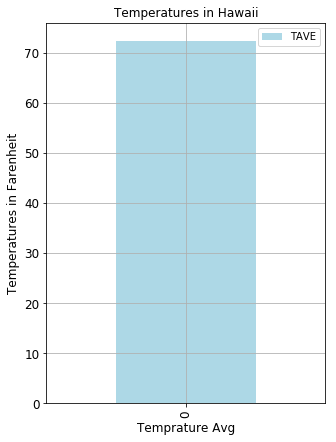

In [10]:
temp_chart = df[['TAVE']].plot(kind='bar', title ="Temperatures in Hawaii", figsize=(5, 7), legend=True, fontsize=12, grid=True, color='lightblue')
temp_chart.set_xlabel("Temprature Avg", fontsize=12)
temp_chart.set_ylabel("Temperatures in Farenheit", fontsize=12)
plt.show()

In [11]:
stations_results = session.query(func.count(Stations.station)).all()
#print("There are " + str(stations_results[0]) + " stations.")

In [13]:
active_results = session.query(Measurements.station,
    label('date', func.count(Measurements.date))).group_by(Measurements.station).all()
#for result in active_results:
 #   print(result)

In [14]:
desc_order = session.query(Measurements.station, func.count(Measurements.tobs)).group_by(Measurements.station).order_by(func.count(Measurements.tobs).desc())
#for result in desc_order:
#    print(result)

In [15]:
obsv_num = session.query(Measurements.station, func.count(Measurements.tobs)).group_by(Measurements.station).order_by(func.count(Measurements.tobs).desc()).first()
#print(obsv_num)

In [16]:
temps = session.query(Measurements.station, Measurements.date, Measurements.tobs).\
    filter(Measurements.date > '2017-01-06').\
    order_by(Measurements.date).all()
#temps

In [17]:
highest_obs = session.query(Measurements.station, Measurements.tobs).\
    filter(Measurements.date > '2017-01-01').\
    group_by(Measurements.station).\
    order_by(func.count(Measurements.tobs).desc()).all()
#highest_obs

In [18]:
df = pd.DataFrame(temps, columns=['Station', 'date', 'temp'])
df.set_index('Station', inplace=True)
#df.head()

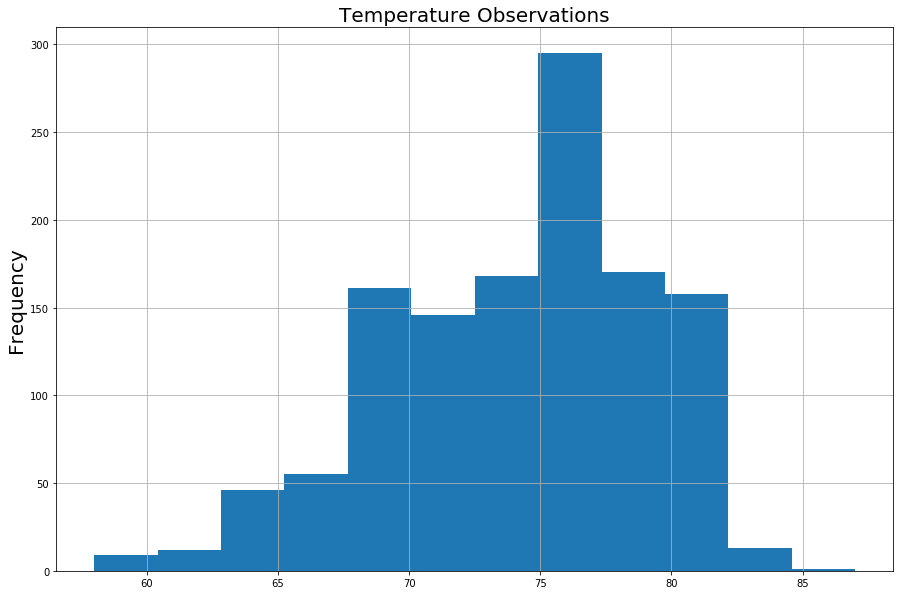

In [19]:
hist_plot = df['temp'].hist(bins=12, figsize=(15,10))
hist_plot.set_title('Temperature Observations', fontsize=20)
hist_plot.set_ylabel('Frequency', fontsize=20)
plt.show()

In [20]:
app = Flask(__name__)

In [21]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///hawaii.sqlite')


from sqlalchemy.ext.automap import automap_base
Base = automap_base()
Base.prepare(engine, reflect=True)


Station = Base.classes.stations
Measurement = Base.classes.measurements
@app.route("/")
def welcome():
    return ("<h1>Hawaii Surf's Up API!</h1>" 
            "<i>Make sure your start and end dates are formatted (Year-Month-Day)</i>"
            "<h2>Available Routes</h2>" 
            "<li>/api/v1.0/precipitation</li>"
            "<li>/api/v1.0/stations</li>"
            "<li>/api/v1.0/tobs</li>"
            "<li>/api/v1.0/start_date</li>" 
            "<li>/api/v1.0/start_date/end_date></li>");

In [22]:
@app.route("/api/v1.0/precipitation")
def precipitation():
    
    results = session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.date <= "2016-01-01", Measurement.date >= "2016-01-01").\
        all()

    #create the JSON objects
    precipitation_list = [results]

    return jsonify(precipitation_list)




In [23]:
@app.route('/api/v1.0/stations')
results = session.query(Station.name, Station.station, Station.elevation).all()

    
    station_list = []
    for result in results:
        row = {}
        row['name'] = result[0]
        row['station'] = result[1]
        row['elevation'] = result[2]
        station_list.append(row)
    return jsonify(station_list)


SyntaxError: invalid syntax (<ipython-input-23-6ccc70349639>, line 2)

In [24]:
@app.route("/api/v1.0/tobs")
def temp_obs():
    
    results = session.query(Station.name, Measurement.date, Measurement.tobs).\
        filter(Measurement.date >= "2016-01-01", Measurement.date <= "2017-01-01").\
        all()

    
    tobs_list = []
    for result in results:
        row = {}
        row["Date"] = result[1]
        row["Station"] = result[0]
        row["Temperature"] = int(result[2])
        tobs_list.append(row)

    return jsonify(tobs_list)


In [25]:
@app.route('/api/v1.0/<date>/')
def given_date(date):
    """Return the average temp, max temp, and min temp for the date"""
    results = session.query(Measurement.date, func.avg(Measurement.tobs), func.max(Measurement.tobs), func.min(Measurement.tobs)).\
        filter(Measurement.date == date).all()


    data_list = []
    for result in results:
        row = {}
        row['Date'] = result[0]
        row['Average Temperature'] = float(result[1])
        row['Highest Temperature'] = float(result[2])
        row['Lowest Temperature'] = float(result[3])
        data_list.append(row)

    return jsonify(data_list)


In [26]:
@app.route('/api/v1.0/<start_date>/<end_date>/')
def query_dates(start_date, end_date):
    
    results = session.query(func.avg(Measurement.tobs), func.max(Measurement.tobs), func.min(Measurement.tobs)).\
        filter(Measurement.date >= start_date, Measurement.date <= end_date).all()

    data_list = []
    for result in results:
        row = {}
        row["Start Date"] = start_date
        row["End Date"] = end_date
        row["Average Temperature"] = float(result[0])
        row["Highest Temperature"] = float(result[1])
        row["Lowest Temperature"] = float(result[2])
        data_list.append(row)
    return jsonify(data_list)

In [ ]:
if __name__ == '__main__':
#    app.run(debug=True, use_reloader=False)
    app.run()

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [17/Apr/2018 16:44:05] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [17/Apr/2018 16:44:05] "GET /favicon.ico HTTP/1.1" 404 -
